In [27]:
import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
from DatasetFromDisk import DatasetFromDisk
import json
import os

## Setup

In [28]:
config_file = open('input_settings_brain_tumor.json')
config_vars = json.load(config_file)
config_file.close()

models_dir = config_vars["models_dir"]

In [29]:
config_file = open('visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

green_color = tuple([x/255 for x in config_vars["green_colors"]["c2"]])

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [31]:
def get_gradcam(img_array, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img

In [32]:
height = 256
width = 256
channels = 3
image_shape = (width, height, channels)
colormap = cv2.COLORMAP_VIRIDIS
data_disk = DatasetFromDisk(width, height, channels, colormap)

In [33]:
# Create the objects to perform performance analysis and visualization
perf_analysis = PerformanceAnalysis()
visual = Visualization()

## Prepare image paths

In [34]:
dataset_folder = ".\\datasets\\brain_tumor"

dataset_folders = [f"{dataset_folder}\\images\\train\\1", f"{dataset_folder}\\images\\train\\2", f"{dataset_folder}\\images\\train\\3", f"{dataset_folder}\\images\\test\\1", f"{dataset_folder}\\images\\test\\2", f"{dataset_folder}\\images\\test\\3"]

train_paths = []
train_labels = []


for folder in dataset_folders:
    paths = os.listdir(folder)
    for path in paths:
        train_paths.append(f"{folder}\\{path}")
        label = int(folder[-1])
        train_labels.append(label)

## Create dataset object

### Train

In [35]:
batch_size = 32

rand_gen = np.random.default_rng(seed=42)

p = rand_gen.permutation(len(train_paths))
train_paths_rand = np.array(train_paths)[p]
train_labels_rand = np.array(train_labels)[p] - 1

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths_rand, train_labels_rand))
train_dataset = train_dataset.map(lambda x, y: data_disk.process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)

### Get examples of the dataset

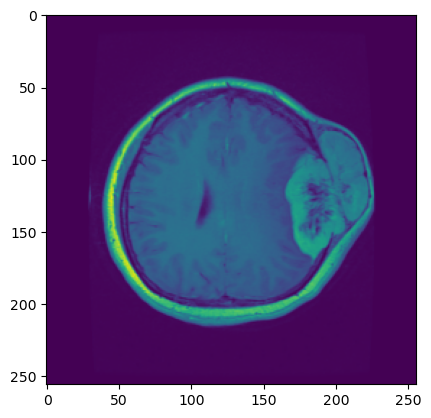

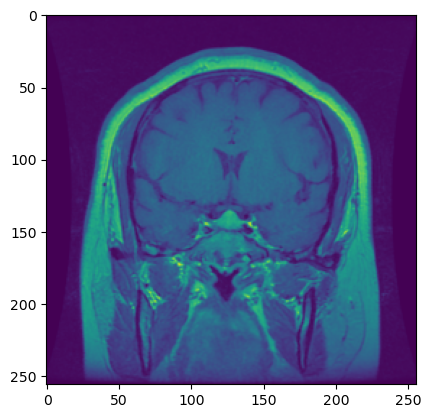

In [36]:
for i, label in train_dataset.take(2):
    plt.imshow(i[0].numpy())
    plt.show()

## Create Raw Convolutional Neural Network (CNN)

In [52]:
# Define the input shape
inputs = layers.Input(shape=image_shape)

# Add convolutional layers and pooling layers
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((3, 3))(x)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((3, 3))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output of the last convolutional layer
x = layers.Flatten()(x)

# Add dense layers
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

# Create the model
cnn_raw = models.Model(inputs=inputs, outputs=outputs)

In [53]:
opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

cnn_raw.compile(loss="sparse_categorical_crossentropy",
optimizer=opt, metrics=["accuracy"])

In [54]:
cnn_raw.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 252, 252, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 84, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 82, 82, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,395 (3.38 MB)

 Trainable params: 885,395 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history_multi1 = cnn_raw.fit(train_dataset, epochs=10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 979ms/step - accuracy: 0.4364 - loss: 12.8678
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 842ms/step - accuracy: 0.5685 - loss: 0.9390
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 851ms/step - accuracy: 0.7022 - loss: 0.6739
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 854ms/step - accuracy: 0.7601 - loss: 0.5476
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 844ms/step - accuracy: 0.7995 - loss: 0.4663
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 845ms/step - accuracy: 0.8244 - loss: 0.3968
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 847ms/step - accuracy: 0.8425 - loss: 0.3700
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - accuracy: 0.8577 - loss: 0.3186
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 81s 844ms/step - accuracy: 0.8906 - loss: 0.2632
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 850ms/step - accuracy: 0.8916 - loss: 0.2467


In [56]:
cnn_raw.save(f"{models_dir}/cnn_raw.keras")

(0.0, 10.0, 0.0, 1.0)

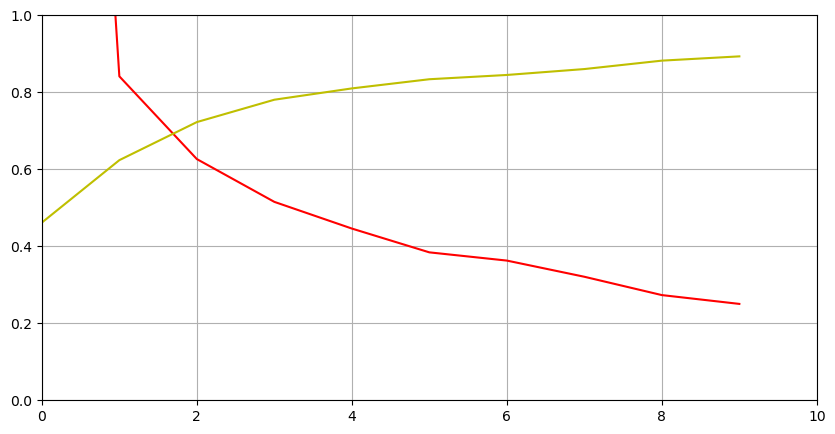

In [57]:
h=history_multi1.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [58]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in train_dataset:
    predictions = cnn_raw.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [59]:
cnn_raw_acc = 1 - np.sum(predicted_classes != all_labels)/len(train_labels)
print(f"Accuracy: {cnn_raw_acc}")

Accuracy: 0.9011096605744126


In [60]:
cnn_raw_cm = confusion_matrix(all_labels, predicted_classes)

Classes,0
0,0.802260
1,0.905330
2,0.969892
Average,0.892494
Accuracy,0.901110


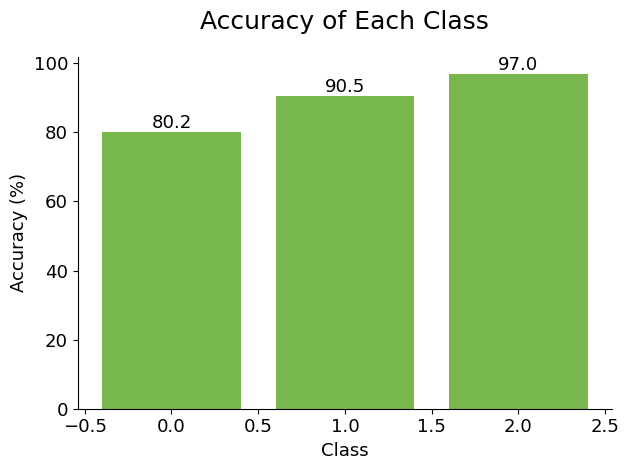

In [116]:
cnn_raw_pd_accs = perf_analysis.acc_for_class(cnn_raw_cm, figure=True, colors=green_color)
plt.savefig(f"{models_dir}/brain_tumor_acc_rawcnn.png", bbox_inches="tight")
cnn_raw_pd_accs.loc[4] = cnn_raw_acc
cnn_raw_pd_accs = cnn_raw_pd_accs.rename(index={4: "Accuracy"})
cnn_raw_pd_accs

## Create CNN by Transfer Learning with VGG16

In [78]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the new model
tl_vgg = models.Model(inputs=base_model.input, outputs=predictions)

In [79]:
optv2 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_vgg.compile(loss="sparse_categorical_crossentropy",
optimizer=optv2, metrics=["accuracy"])

In [80]:
tl_vgg.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [81]:
history_multi2 = tl_vgg.fit(train_dataset, epochs=10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.6532 - loss: 4.2681
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.8946 - loss: 0.2700
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.9185 - loss: 0.2060
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.9316 - loss: 0.1720
Epoch 5/10
48/96 ━━━━━━━━━━━━━━━━━━━━ 3:55 5s/step - accuracy: 0.9473 - loss: 0.1555


KeyboardInterrupt



In [66]:
tl_vgg.save(f"{models_dir}/vgg16.keras")

In [67]:
vgg_disk = load_model(f"{models_dir}/vgg16.keras")
tl_vgg = vgg_disk

(0.0, 10.0, 0.0, 1.0)

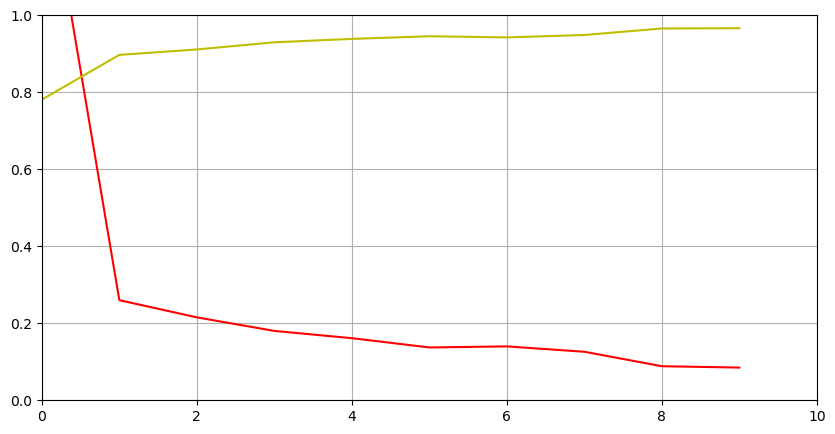

In [68]:
h=history_multi2.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [70]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in train_dataset:
    predictions = tl_vgg.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [72]:
tl_vgg_acc = 1 - np.sum(predicted_classes != all_labels)/len(train_labels)
print(f"Accuracy: {tl_vgg_acc}")

Accuracy: 0.9631201044386423


In [73]:
tl_vgg_cm = confusion_matrix(all_labels, predicted_classes)

Classes,0
0,0.874294
1,0.990884
2,0.988172
Average,0.951116
Accuracy,0.963120


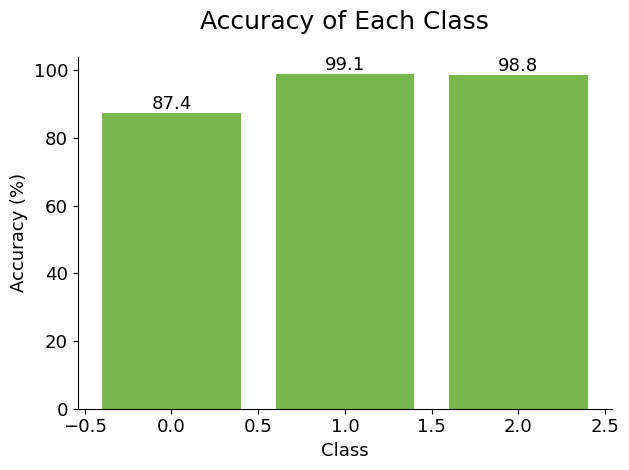

In [115]:
tl_vgg_pd_accs = perf_analysis.acc_for_class(tl_vgg_cm, figure=True, colors=green_color)
plt.savefig(f"{models_dir}/brain_tumor_acc_vgg.png", bbox_inches="tight")
tl_vgg_pd_accs.loc[4] = tl_vgg_acc
tl_vgg_pd_accs = tl_vgg_pd_accs.rename(index={4: "Accuracy"})
tl_vgg_pd_accs

## Create CNN by Transfer Learning with MobileNetV2

In [82]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the new model
tl_mn = models.Model(inputs=base_model.input, outputs=predictions)

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [83]:
optv3 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_mn.compile(loss="sparse_categorical_crossentropy",
optimizer=optv3, metrics=["accuracy"])

In [84]:
tl_mn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [85]:
history_multi3 = tl_mn.fit(train_dataset, epochs=10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6685 - loss: 1.1888
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8723 - loss: 0.3311
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8956 - loss: 0.2810
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9149 - loss: 0.2410
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9245 - loss: 0.2108
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9352 - loss: 0.1838
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9417 - loss: 0.1701
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9483 - loss: 0.1500
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9475 - loss: 0.1450
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9491 - loss: 0.1376


In [86]:
tl_mn.save(f"{models_dir}/mbnet.keras")

In [87]:
mbnet_disk = load_model(f"{models_dir}/mbnet.keras")
tl_mn = mbnet_disk

(0.0, 10.0, 0.0, 1.0)

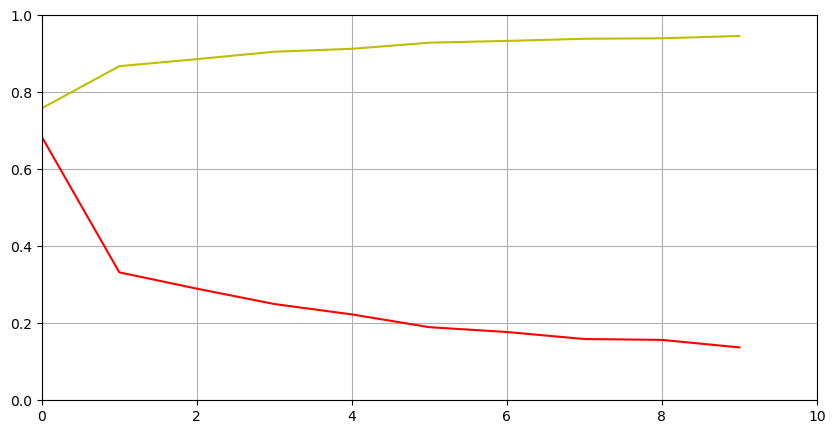

In [88]:
h=history_multi3.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [89]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in train_dataset:
    predictions = tl_mn.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [90]:
tl_mn_acc = 1 - np.sum(predicted_classes != all_labels)/len(train_labels)
print(f"Accuracy: {tl_mn_acc}")

Accuracy: 0.9392950391644909


In [91]:
tl_mn_cm = confusion_matrix(all_labels, predicted_classes)

Classes,0
0,0.939266
1,0.901823
2,0.996774
Average,0.945954
Accuracy,0.939295


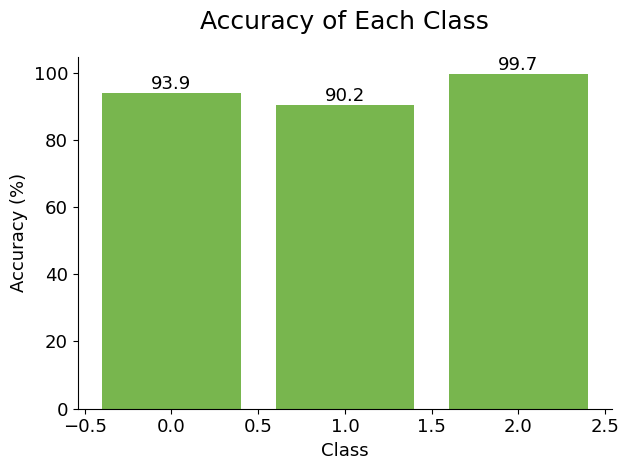

In [114]:
tl_mn_pd_accs = perf_analysis.acc_for_class(tl_mn_cm, figure=True, colors=green_color)
plt.savefig(f"{models_dir}/brain_tumor_acc_mbnet.png", bbox_inches="tight")
tl_mn_pd_accs.loc[4] = tl_mn_acc
tl_mn_pd_accs = tl_mn_pd_accs.rename(index={4: "Accuracy"})
tl_mn_pd_accs

## Create CNN by Transfer Learning with RESNet50

In [96]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x) 

# Create the new model
tl_rn = models.Model(inputs=base_model.input, outputs=predictions)

In [97]:
optv4 = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
beta_2=0.99)

tl_rn.compile(loss="sparse_categorical_crossentropy",
optimizer=optv4, metrics=["accuracy"])

In [98]:
tl_rn.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [99]:
history_multi4 = tl_rn.fit(train_dataset, epochs=10)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.6551 - loss: 3.5023
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8995 - loss: 0.2429
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9236 - loss: 0.1936
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9363 - loss: 0.1573
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9483 - loss: 0.1275
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9462 - loss: 0.1293
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9604 - loss: 0.1104
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9647 - loss: 0.0884
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9649 - loss: 0.0860
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9644 - loss: 0.0867


In [100]:
tl_rn.save(f"{models_dir}/resnet.keras")

In [101]:
resnet_disk = load_model(f"{models_dir}/resnet.keras")
tl_rn = resnet_disk

(0.0, 10.0, 0.0, 1.0)

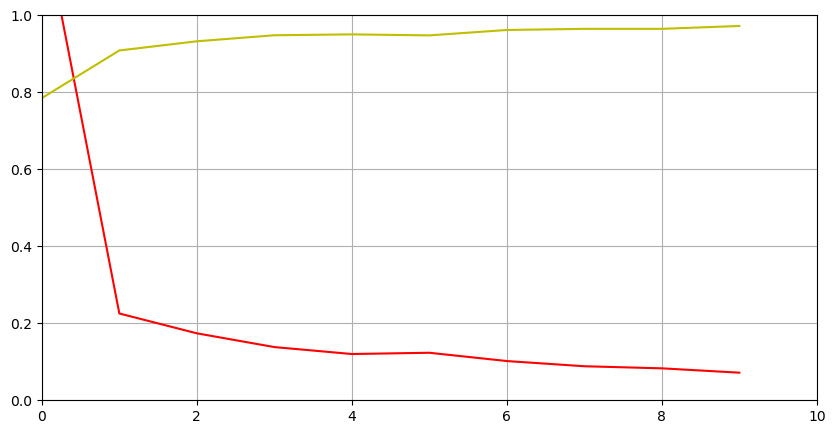

In [102]:
h=history_multi4.history
plt.figure(figsize=(10,5))
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "y")
plt.grid(True)
plt.axis([0,10,0,1])

In [104]:
# Predict on the entire test dataset
all_predictions = []
all_labels = []

for images, labels in train_dataset:
    predictions = tl_rn.predict(images, verbose=0)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

predicted_classes = np.argmax(all_predictions, axis=1)

In [105]:
tl_rn_acc = 1 - np.sum(predicted_classes != all_labels)/len(train_labels)
print(f"Accuracy: {tl_rn_acc}")

Accuracy: 0.9817232375979112


In [106]:
tl_rn_cm = confusion_matrix(all_labels, predicted_classes)

Classes,0
0,0.926554
1,0.997896
2,0.998925
Average,0.974458
Accuracy,0.981723


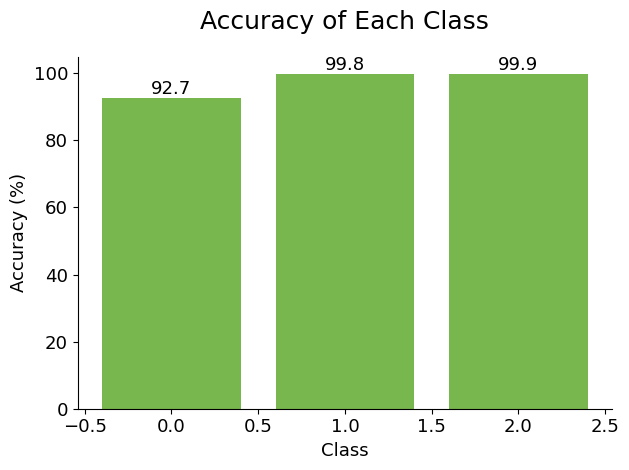

In [113]:
tl_rn_pd_accs = perf_analysis.acc_for_class(tl_rn_cm, figure=True, colors=green_color)
plt.savefig(f"{models_dir}/brain_tumor_acc_resnet.png", bbox_inches="tight")
tl_rn_pd_accs.loc[4] = tl_rn_acc
tl_rn_pd_accs = tl_rn_pd_accs.rename(index={4: "Accuracy"})
tl_rn_pd_accs

# Summary

## Metrics

In [108]:
cnn_raw_metrics = cnn_raw_pd_accs.rename(columns={0: "Raw CNN"})
cnn_raw_metrics["Raw CNN"] = [round(x, 2) for x in cnn_raw_metrics["Raw CNN"]]
tl_vgg_metrics = tl_vgg_pd_accs.rename(columns={0: "VGG"})
tl_vgg_metrics["VGG"] = [round(x, 2) for x in tl_vgg_metrics["VGG"]]
tl_mn_metrics = tl_mn_pd_accs.rename(columns={0: "MNet"})
tl_mn_metrics["MNet"] = [round(x, 2) for x in tl_mn_metrics["MNet"]]
tl_rn_metrics = tl_rn_pd_accs.rename(columns={0: "ResNet"})
tl_rn_metrics["ResNet"] = [round(x, 2) for x in tl_rn_metrics["ResNet"]]


overall_metrics = pd.concat([cnn_raw_metrics, tl_vgg_metrics, tl_mn_metrics, tl_rn_metrics], axis=1)
display(overall_metrics)

Classes,Raw CNN,VGG,MNet,ResNet
0,0.80,0.87,0.94,0.93
1,0.91,0.99,0.90,1.00
2,0.97,0.99,1.00,1.00
Average,0.89,0.95,0.95,0.97
Accuracy,0.90,0.96,0.94,0.98


In [109]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [110]:
for i, row in overall_metrics.iterrows():
    
    aux_str = str(i)
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{models_dir}/brain_tumor_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Visual Accuracy per class

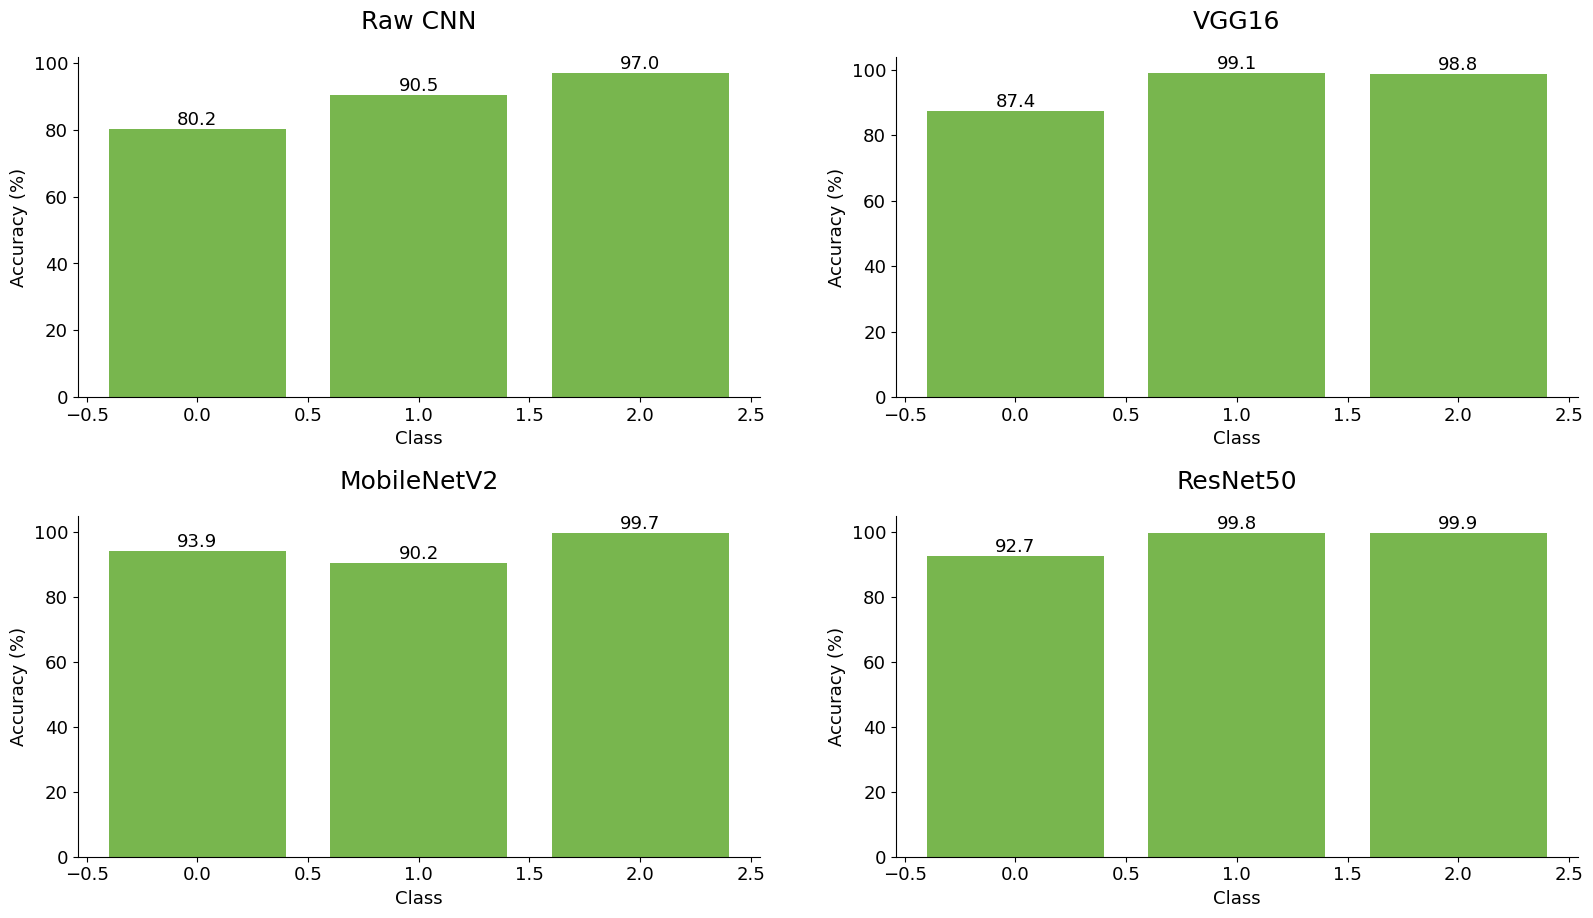

In [111]:
visual.acc_classes([cnn_raw_cm, tl_vgg_cm, tl_mn_cm, tl_rn_cm],
                  nrows=2, 
                  ncols=2, 
                  figsize=(15,8),
                  title_size=title_size,
                  label_size=label_size,
                  colors=[green_color, green_color, green_color, green_color],
                  titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"])

plt.savefig(f"{models_dir}/brain_tumor_acc_classes.png", bbox_inches="tight")

plt.show()

## Confusion Matrices

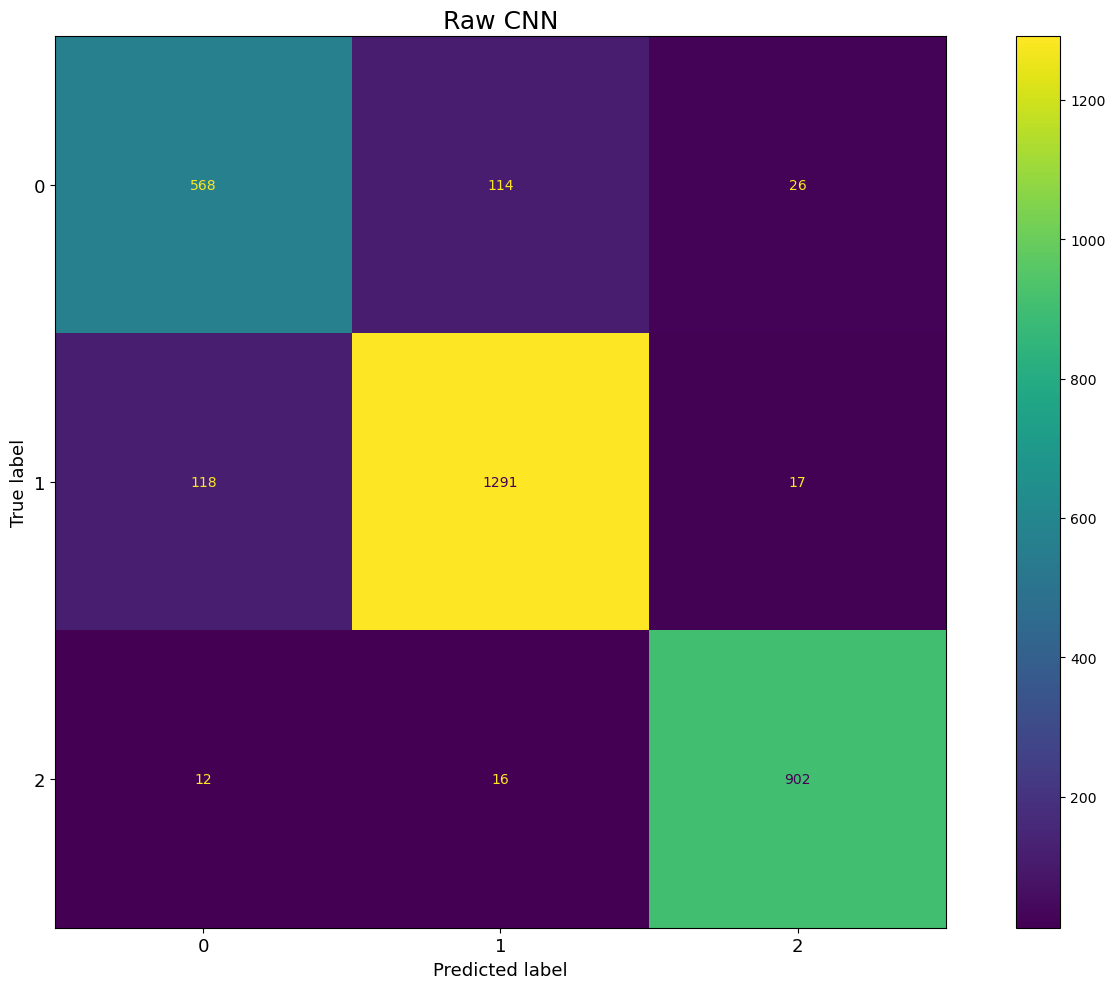

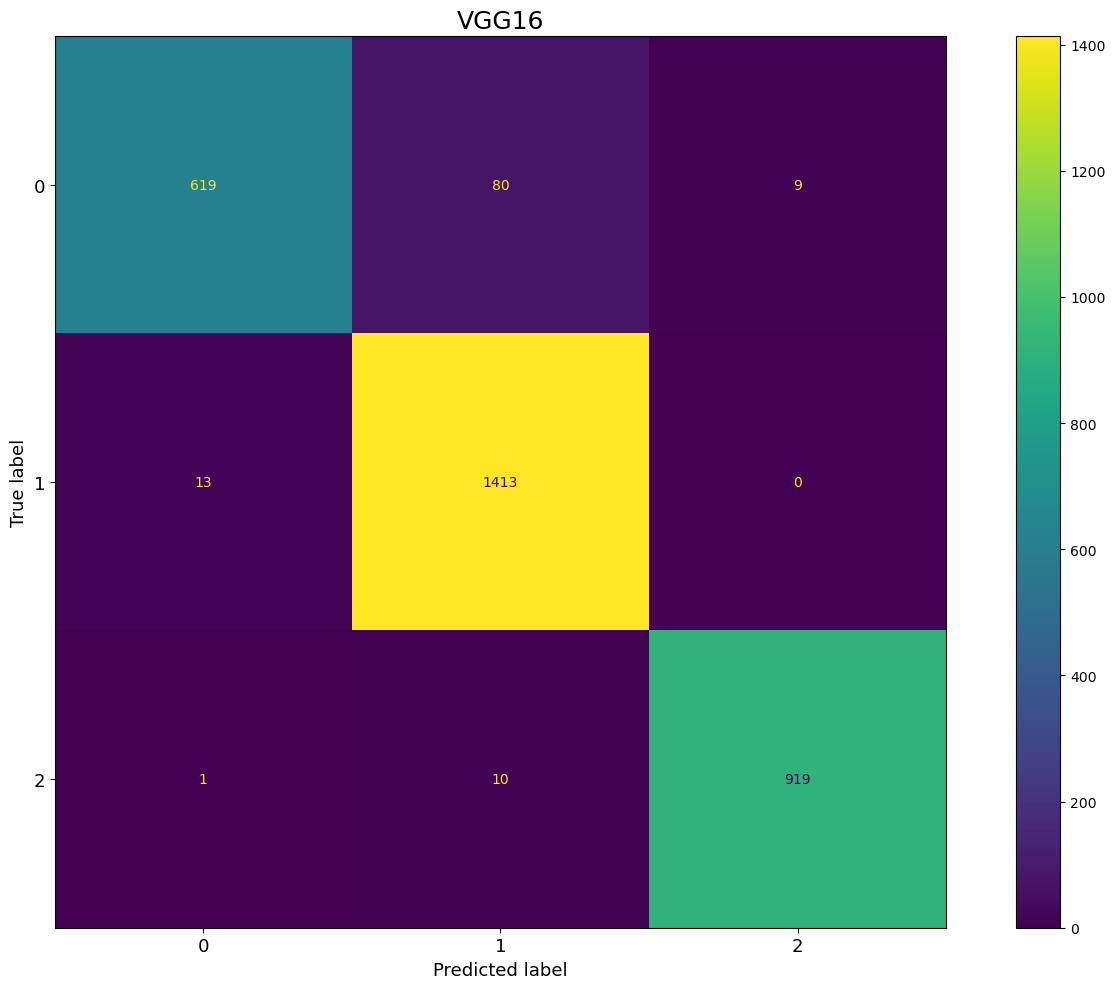

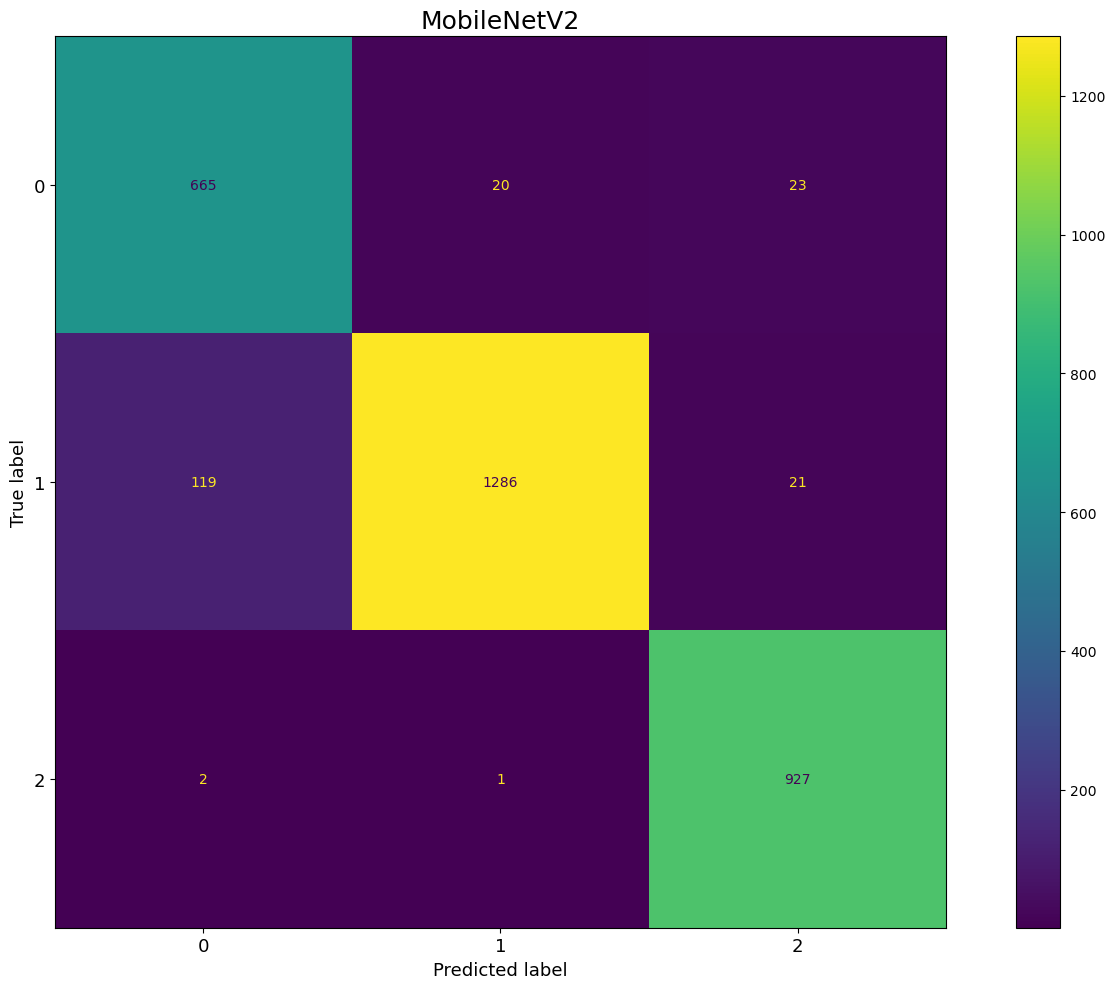

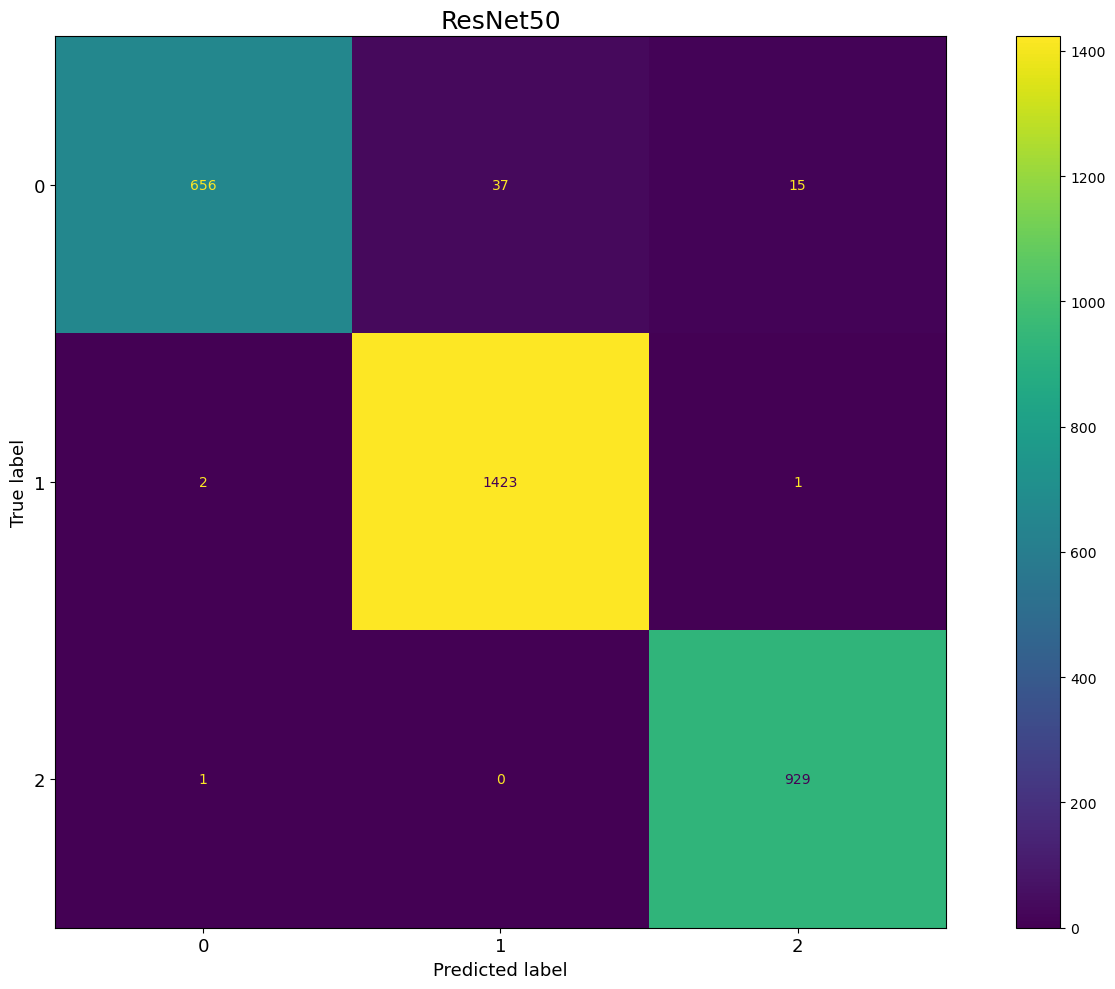

In [112]:
visual.confusion_matrices([cnn_raw_cm, tl_vgg_cm, tl_mn_cm, tl_rn_cm],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"],
                            save_name=f"{models_dir}/brain_tumor_conf_mat"
                          )

# plt.savefig(f"{logs_dir}/brain_tumor_conf_matrices.png", bbox_inches="tight")
# 
# plt.show()